# NASA: Asteroids Classification

### Overview

We were provided the NASA asteroids classification [dataset](https://www.kaggle.com/datasets/lovishbansal123/nasa-asteroids-classification). The dataset contains information about near-Earth asteroids, including features such as diameter, orbital period, semi-major axis, and whether they are hazardous.

### Project Objectives

1. **Identify Hazardous Asteroids**: Use the AI system to classify asteroids.
2. **Feature Analysis**: Identify key features for classification.
3. **Model Comparison**: Compare different machine learning algorithms.


In [159]:
# Import all nessesary libraries
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump, load
from tqdm import tqdm
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set warnings 
warnings.filterwarnings('ignore')

## Data processing

### Data loading

In [160]:
path = 'data/nasa.csv'
data = pd.read_csv(path)
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.600,0.127,0.284,127.220,284.472,0.079,0.177,417.388,...,314.374,609.600,0.808,57.257,2.006,2458161.642,264.838,0.591,J2000,True
1,3723955,3723955,21.300,0.146,0.327,146.068,326.618,0.091,0.203,479.226,...,136.717,425.869,0.718,313.092,1.497,2457794.969,173.741,0.845,J2000,False
2,2446862,2446862,20.300,0.232,0.518,231.502,517.654,0.144,0.322,759.521,...,259.476,643.580,0.951,248.415,1.967,2458120.468,292.894,0.559,J2000,True
3,3092506,3092506,27.400,0.009,0.020,8.801,19.681,0.005,0.012,28.876,...,57.173,514.082,0.984,18.708,1.528,2457902.337,68.741,0.700,J2000,False
4,3514799,3514799,21.600,0.127,0.284,127.220,284.472,0.079,0.177,417.388,...,84.629,495.598,0.968,158.264,1.484,2457814.455,135.142,0.726,J2000,True


In [161]:
data.info()
data['Hazardous'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

Hazardous
False    3932
True      755
Name: count, dtype: int64

## Data Analysis

### Missing Values

Check for Missing Values (NA) in a DataFrame:

In [162]:
print(f"Is any data NA: {data.isna().any().any()}")

Is any data NA: False


### Visualizing Correlation Matrix Using Heatmap

The purpose of this code snippet is to create a heatmap using seaborn to visualize the correlation matrix of relationships between different numerical columns in the dataset. Using that we can drop the unnecessary columns to optimize our models or analysis.

In [163]:
# plt.figure(figsize=(32,32))
# sb.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f')
# plt.show()

### Analyzing High Correlations in Columns

Based on the results, several columns have high correlations:

1. **Name** and **Neo Reference ID**: These are just identifiers and do not contain useful information for analysis.

2. **Est Dia in M(min)**, **Est Dia in Miles(min)** ... : All these values represent the same measurements but in different units. We can drop all but one.

3. **Relative Velocity km per hr** and **Miles per hour**: Similar to the previous case, these values represent the same information but in different units.

4. **Miss Dist.(Astronomical)** and **Miss Dist.(lunar)**: These also represent the same information but in different units.

5. **Orbital Period**: This has a perfect correlation (1.0) with **Semi Major Axis**, due to the formula $T^2 = \text{const} \cdot a^3$, where $T$ is the Orbital Period and $a$ is the Semi Major Axis. We can drop one of them.

6. **Est Dia in KM(max)**, **Jupiter Tisserand Invariant**, **Epoch Osculation**, **Aphelion Dist**: These columns have high correlations with other values.

Additionally, we can drop the columns **Equinox** and **Orbiting Body**, as they contain only a single unique value: *J2000* and *Earth*, respectively.


In [164]:
print(f"Unique Equinox values: {data['Equinox'].nunique()}")
print(f"Unique Orbiting Body values: {data['Orbiting Body'].nunique()}")

data = data.drop(['Name', 'Neo Reference ID', 'Orbit ID',   # IDs
                    'Orbit Determination Date', 'Close Approach Date', # Date
                    'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', # Distance
                    'Relative Velocity km per hr', 'Miles per hour', # Velocity
                    'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(miles)', # # Distance
                    'Equinox',            # all 'J2000' 
                    'Orbiting Body',      # all 'Earth'
                    'Orbital Period',     # T² = const * a³, => corr = 1 with Semi Major Axis (a)
                    'Est Dia in KM(max)', # High correlation with Est Dia in KM(min)
                    'Jupiter Tisserand Invariant', # High correlation with Mean Motion
                    'Epoch Osculation',   # High correlation with Perihelion Time
                    'Aphelion Dist',      # High correlation with Semi Major Axis
                    ] , axis = 1)

data['Hazardous'] = data['Hazardous'].astype(int)

data.head()

Unique Equinox values: 1
Unique Orbiting Body values: 1


,Absolute Magnitude,Est Dia in KM(min),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.600,0.127,788947200000,6.116,62753692.000,5,0.025,0.426,1.407,6.026,314.374,0.808,57.257,2458161.642,264.838,0.591,1
1,21.300,0.146,788947200000,18.114,57298148.000,3,0.187,0.352,1.108,28.413,136.717,0.718,313.092,2457794.969,173.741,0.845,0
2,20.300,0.232,789552000000,7.591,7622911.500,0,0.043,0.348,1.459,4.238,259.476,0.951,248.415,2458120.468,292.894,0.559,1
3,27.400,0.009,790156800000,11.174,42683616.000,6,0.006,0.217,1.256,7.906,57.173,0.984,18.708,2457902.337,68.741,0.700,0
4,21.600,0.127,790156800000,9.841,61010824.000,1,0.035,0.210,1.226,16.793,84.629,0.968,158.264,2457814.455,135.142,0.726,1


New Correlation Matrix:

In [165]:
# plt.figure(figsize=(20,20))
# sb.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f')
# plt.show()

### Dropping outliers

The goal of this section is to identify and potentially remove outliers from the dataset. 

Plotting Pairwise Relationships:

In [166]:
# plt.figure()
# sb.pairplot(data.dropna(), hue='Hazardous')
# plt.show()

Filter out outliers based on specific conditions, based on the estimated diameter (min) in kilometers, semi-major axis, and inclination, keeping only reasonable values.

In [167]:
# Filter out outliers based on specific conditions
df_no_outliers = data[(data['Est Dia in KM(min)'] <= 10) & 
                    (data['Semi Major Axis'] <= 4) &
                    (data['Inclination'] < 70)]

# Reset the index of the filtered DataFrame
df_no_outliers.reset_index(inplace=True, drop=True)

print(f"Number of objects before: {data.shape[0]}, after: {df_no_outliers.shape[0]}, dropped: {data.shape[0] - df_no_outliers.shape[0]} objects.")

Number of objects before: 4687, after: 4683, dropped: 4 objects.


In [168]:
# plt.figure()
# sb.pairplot(df_no_outliers.dropna(), hue='Hazardous')
# plt.show()

### Save clean data

In [169]:
clean_data_path = 'data/nasa_clean.csv'
print(f"Saving data to {clean_data_path} ...")
df_no_outliers.to_csv(clean_data_path, index=False)

Saving data to data/nasa_clean.csv ...


## Models training

### Preparation

Separate the features (X) and the target variable (y)

In [170]:
X = df_no_outliers.drop(['Hazardous'], axis=1)
y = df_no_outliers['Hazardous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Scale the numerical features of the dataset to have zero mean and unit variance. This standardization helps to improve the performance of many machine learning algorithms.

In [171]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, X.columns.to_list()),
])

preprocessor.fit(X_train)

x_train_transformed = preprocessor.transform(X_train)
x_test_transformed = preprocessor.transform(X_test)

print("Transformed data:")
pd.DataFrame(x_train_transformed, columns=X.columns).head()

Transformed data:


,Absolute Magnitude,Est Dia in KM(min),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion
0,-0.608,0.029,0.404,1.306,1.552,0.816,-0.634,2.352,1.542,-0.733,0.439,-1.575,0.816,-0.148,-0.538,-1.275
1,-0.851,0.297,0.003,1.715,0.968,-1.131,-0.063,0.672,0.773,1.202,0.705,0.344,1.063,0.029,-0.768,-0.967
2,0.609,-0.536,-1.400,0.108,0.794,0.167,-0.796,-1.311,-0.512,-0.864,-1.652,0.626,0.469,0.318,1.436,0.231
3,-0.608,0.029,-0.166,-0.576,-0.717,-1.131,-0.588,-1.718,-0.759,0.120,-1.284,0.473,-0.735,0.099,-0.074,0.706
4,-0.469,-0.090,-0.843,-0.921,1.275,-0.158,1.240,-0.548,0.194,-0.187,-0.436,1.077,-0.901,0.071,-0.671,-0.591


In [172]:
def plot_metric_resuts(df_results, names):
    scores = ['Acc Test', 'Pre Test', 'Rec Test', 'F1 Test']
    heatmap_data = df_results[scores].transpose()

    plt.figure(figsize=(12, 6))
    ax = sb.heatmap(heatmap_data, annot=True, cmap='Blues', cbar=True, xticklabels=names, yticklabels=scores)
    ax.set_title("Model Performance Heatmap (Test Set)")
    ax.set_xlabel("Models")
    ax.set_ylabel("Metrics")
    plt.tight_layout()
    plt.show()

def plot_boxplots(results_acc, results_pre, results_rec, results_f1, names):
    # Create boxplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

    plot_titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    results_list = [results_acc, results_pre, results_rec, results_f1]

    palette = sb.color_palette("Blues")
    for ax, title, result in zip(axes, plot_titles, results_list):
        sb.boxplot(data=result, ax=ax, palette=palette)
        ax.set_title(title, fontsize=14)
        ax.set_xticklabels(names, rotation=30)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(models, confusion_matrices, names):
    # Create Confusion Matrices
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))
    if len(models) == 1:
        axes = [axes]
    for ax, cm, name in zip(axes, confusion_matrices, names):
        sb.heatmap(cm / np.sum(cm), annot=True, fmt=".2%", ax=ax, cmap='Blues')
        ax.set_title(f'{name} Confusion Matrix')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    plt.tight_layout()
    plt.show()

In [173]:
def model_evaluation(x_train, y_train, x_test, y_test, models):
    names = []
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Train Mean', 'Acc Train STD', 'Pre Train Mean', 'Pre Train STD', 
                                       'Rec Train Mean', 'Rec Train STD', 'F1 Train Mean', 'F1 Train STD',
                                       'Acc Test', 'Pre Test', 'Rec Test', 'F1 Test', 'Training Time'])
    results_acc_test = []
    results_pre_test = []
    results_rec_test = []
    results_f1_test = []
    results_acc = []
    results_pre = []
    results_rec = []
    results_f1 = [] 
    confusion_matrices = []
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for name, model in tqdm(models, total=len(models)):
        names.append(name)

        # Cross-validation results on the training set
        result = cross_validate(model, x_train, y_train, cv=kfold, scoring=scoring, return_train_score=False)
        model.fit(x_train, y_train)
        
        # Test set results
        predictions = model.predict(x_test)
        cm = confusion_matrix(y_test, predictions)
        confusion_matrices.append(cm)
        accuracy_test = accuracy_score(y_test, predictions)
        precision_test = precision_score(y_test, predictions, zero_division=1)
        recall_test = recall_score(y_test, predictions)
        f1_test = f1_score(y_test, predictions)
        
        # Store the test set results (single values)
        results_acc_test.append(accuracy_test)
        results_pre_test.append(precision_test)
        results_rec_test.append(recall_test)
        results_f1_test.append(f1_test)
        results_acc.append(result['test_accuracy'])
        results_pre.append(result['test_precision'])
        results_rec.append(result['test_recall'])
        results_f1.append(result['test_f1'])

        # Row of results
        model_results = pd.DataFrame({'Algorithm': name, 
                                      'Acc Test': accuracy_test,
                                      'Pre Test': precision_test,
                                      'Rec Test': recall_test,
                                      'F1 Test': f1_test,
                                      'Acc Train Mean': result['test_accuracy'].mean(), 
                                      'Acc Train STD': result['test_accuracy'].std(), 
                                      'Pre Train Mean': result['test_precision'].mean(), 
                                      'Pre Train STD': result['test_precision'].std(), 
                                      'Rec Train Mean': result['test_recall'].mean(), 
                                      'Rec Train STD': result['test_recall'].std(), 
                                      'F1 Train Mean': result['test_f1'].mean(), 
                                      'F1 Train STD': result['test_f1'].std(),
                                      'Training Time': result['fit_time'].mean(),
                                      }, index=[0])
        
        # Add the row to the results data frame
        if not model_results.empty:
            df_results = pd.concat([df_results, model_results], ignore_index=True)
        
        # Save model.
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # dump(model, f'models/{name}_{current_time}_classifier.joblib')


    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    pd.set_option('display.width', 1000)
    print(df_results)


    # Show different plots
    plot_metric_resuts(df_results, names)
    plot_boxplots(results_acc, results_pre, results_rec, results_f1, names)
    plot_confusion_matrices(models, confusion_matrices, names)

100%|██████████| 6/6 [00:33<00:00,  5.51s/it]

           Acc Train Mean  Acc Train STD  Pre Train Mean  Pre Train STD  Rec Train Mean  Rec Train STD  F1 Train Mean  F1 Train STD  Acc Test  Pre Test  Rec Test  F1 Test  Training Time
Algorithm                                                                                                                                                                                
SVC                 0.946          0.008           0.866          0.028           0.786          0.040          0.823         0.026     0.956     0.893     0.828    0.859          0.069
DTC                 0.994          0.004           0.984          0.016           0.978          0.018          0.981         0.012     1.000     1.000     1.000    1.000          0.012
KNN                 0.902          0.013           0.760          0.053           0.574          0.059          0.653         0.055     0.903     0.806     0.523    0.635          0.001
GNB                 0.948          0.009           0.836          0.02

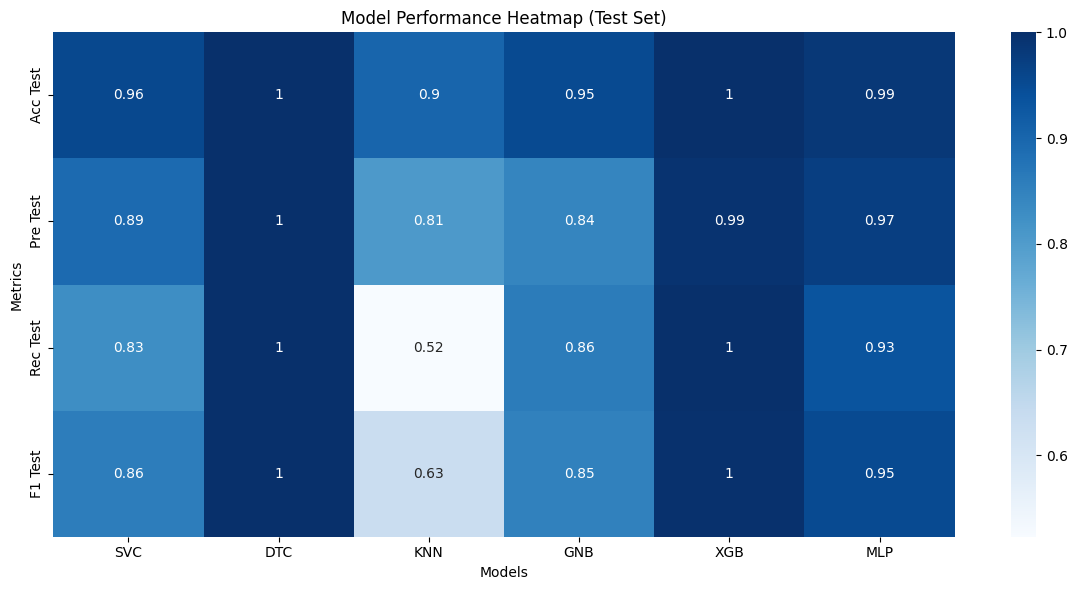

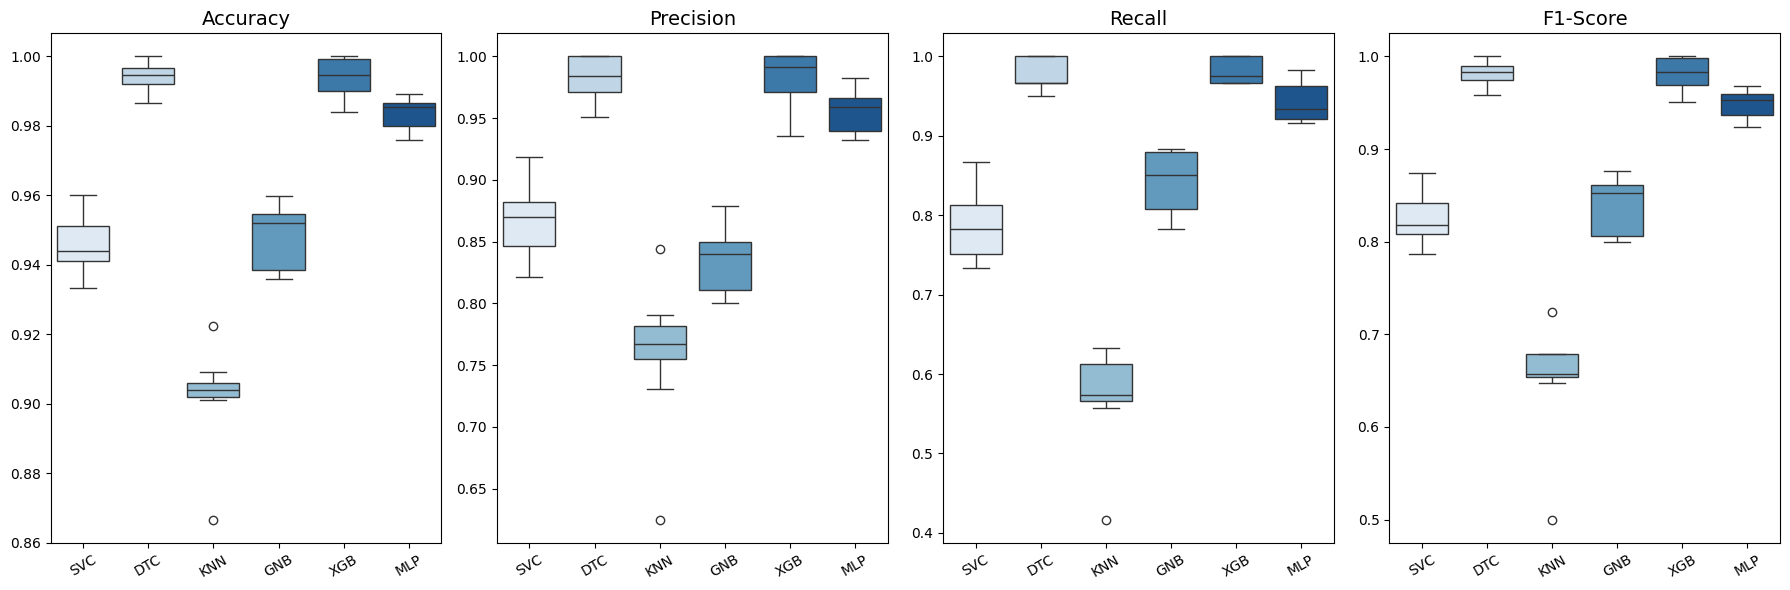

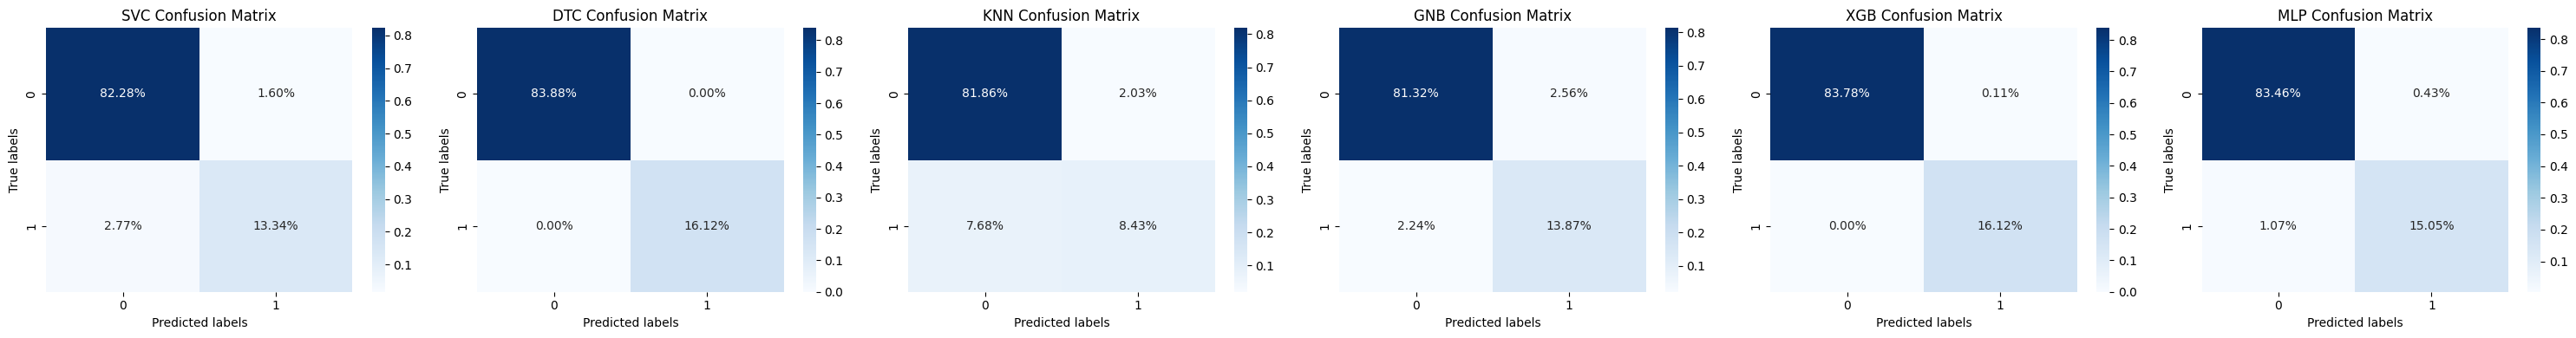

In [174]:
models = []
models.append(('SVC', SVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('MLP', MLPClassifier()))

model_evaluation(x_train_transformed, y_train, x_test_transformed, y_test, models)

100%|██████████| 3/3 [00:22<00:00,  7.49s/it]

           Acc Train Mean  Acc Train STD  Pre Train Mean  Pre Train STD  Rec Train Mean  Rec Train STD  F1 Train Mean  F1 Train STD  Acc Test  Pre Test  Rec Test  F1 Test  Training Time
Algorithm                                                                                                                                                                                
RFC                 0.996          0.003           0.990          0.013           0.985          0.017          0.987         0.009     0.996     0.993     0.980    0.987          0.390
ABC                 0.994          0.003           0.985          0.012           0.978          0.017          0.982         0.009     0.997     1.000     0.980    0.990          0.309
GBC                 0.995          0.003           0.992          0.011           0.975          0.013          0.983         0.008     0.998     0.993     0.993    0.993          1.294


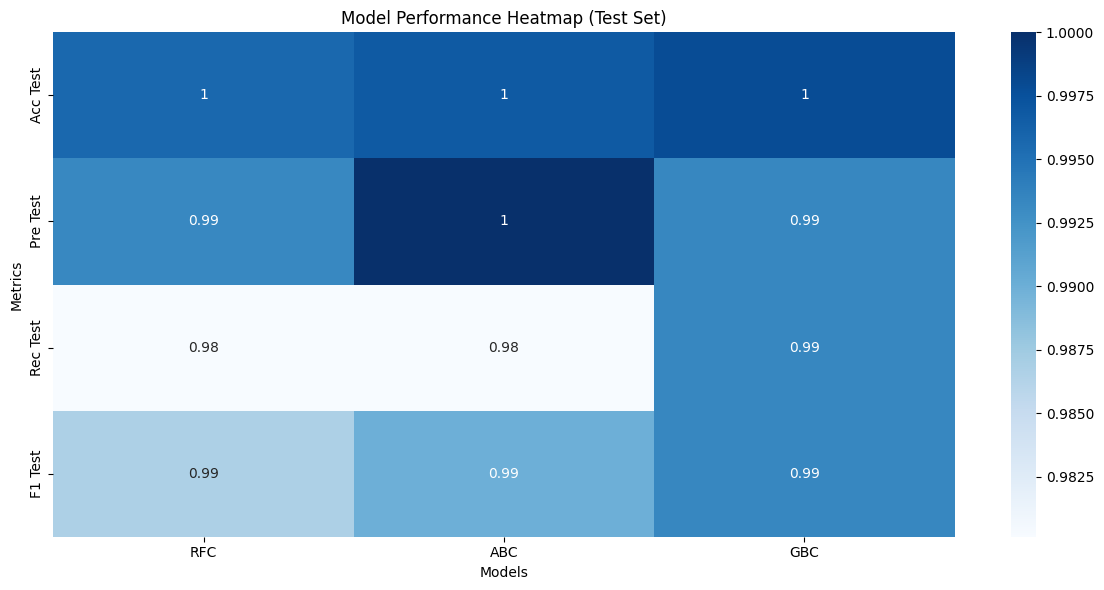

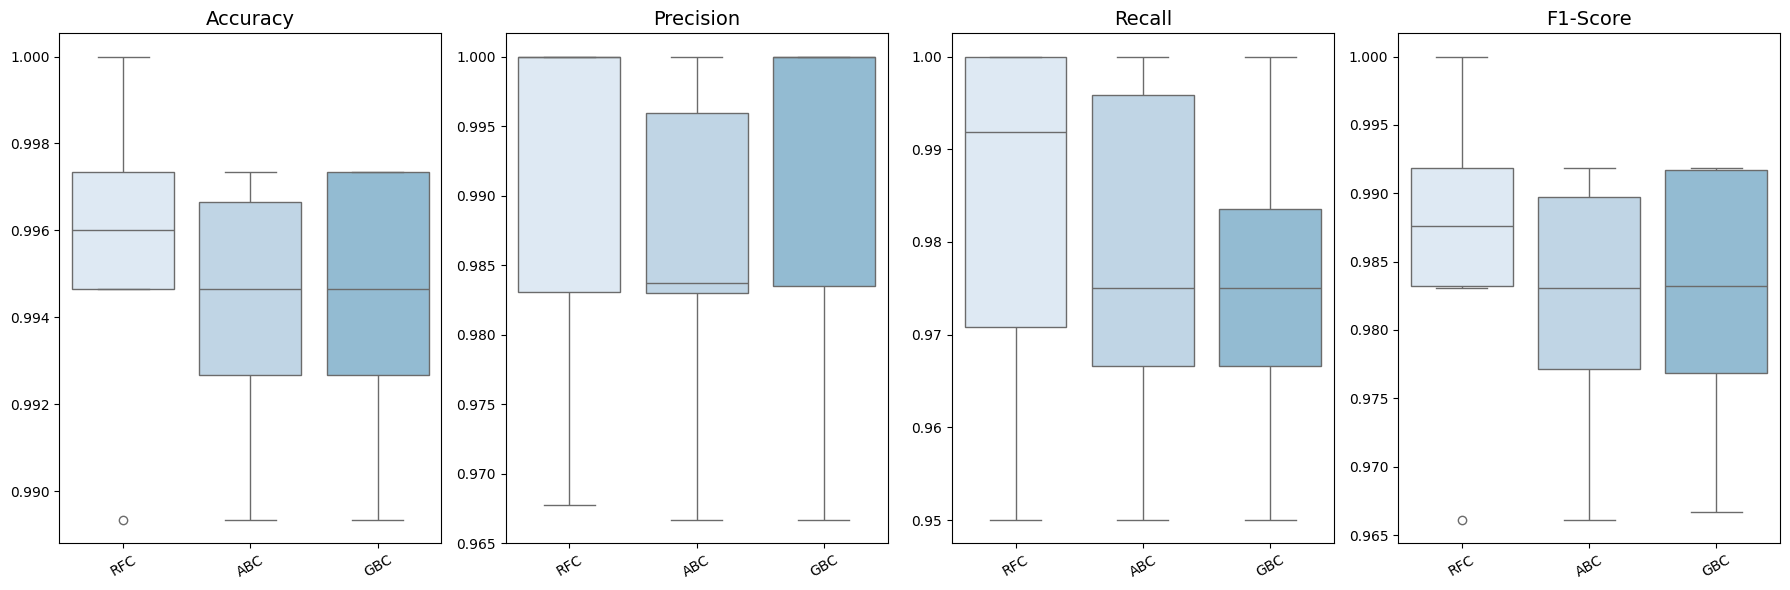

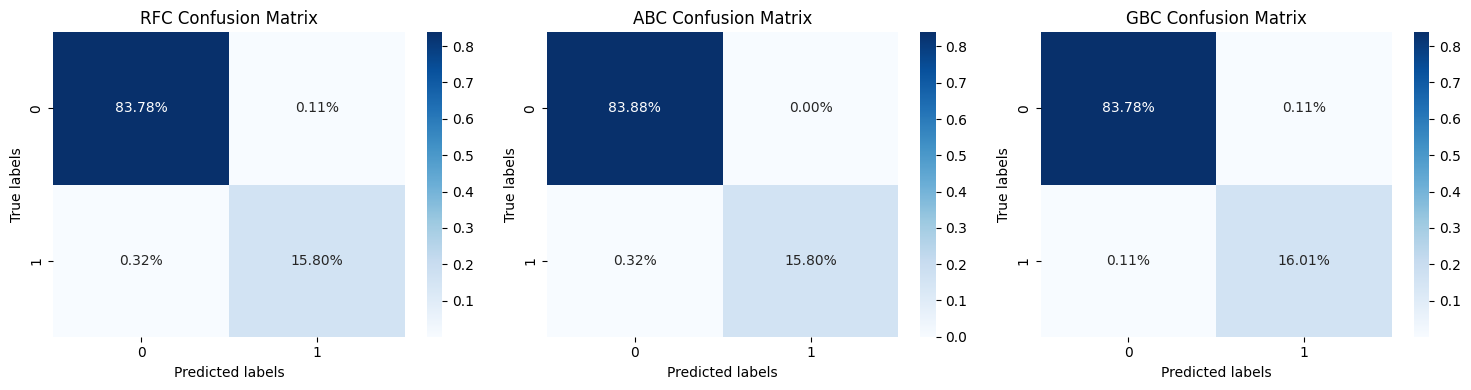

In [175]:
models = []
models.append(('RFC', RandomForestClassifier()))
models.append(('ABC', AdaBoostClassifier(algorithm='SAMME')))
models.append(('GBC', GradientBoostingClassifier()))

model_evaluation(x_train_transformed, y_train, x_test_transformed, y_test, models)

In [176]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth': [None, 5, 10, 20, 30],  
    'min_samples_split' : [1, 2, 3],
    'criterion': ['gini', 'entropy']  
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(x_train_transformed, y_train)

best_rf = grid_search.best_estimator_

predictions = best_rf.predict(x_test_transformed)

accuracy = accuracy_score(y_test, predictions)

print("Best parameters found: ", grid_search.best_params_)
print("Test accuracy of the best model: ", accuracy)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy of the best model:  0.9989327641408752


In [177]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [15, 20, 30, 40], 
    'p': [1, 1.25, 1.5, 1.75, 2]  
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(x_train_transformed, y_train)

best_knn = grid_search.best_estimator_

predictions = best_knn.predict(x_test_transformed)
accuracy = accuracy_score(y_test, predictions)

print("Best parameters found: ", grid_search.best_params_)
print("Test accuracy of the best model: ", accuracy)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters found:  {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Test accuracy of the best model:  0.9327641408751334
